### Stochastic Oscillator

<font color='orange'>
    A stochastic oscillator is a momentum indicator comparing a particular closing price of a security to a range of its prices over a certain period of time. The sensitivity of the oscillator to market movements is reducible by adjusting that time period or by taking a moving average of the result. It is used to generate overbought and oversold trading signals, utilizing a 0–100 bounded range of values.<br>
    The closing price tends to close near the high in an uptrend and near the low in a downtrend. If the closing price then slips away from the high or the low, then momentum is slowing. Stochastics are most effective in broad trading ranges or slow moving trends.
    $$
    \% \mathrm{~K}=\left(\frac{\mathrm{C}-\mathrm{L} 14}{\mathrm{H} 14-\mathrm{L} 14}\right) \times 100
    $$
    where:
    $$
    \begin{aligned}
    \mathrm{C}&:\text { The most recent closing price } \\
    \mathrm{L14}&:\text { The lowest price traded of the 14 previous trading sessions } \\
    \mathrm{H14}&:\text { The highest price traded during the same 14-day period } \\
    \% \mathrm{~K}&:\text { The current value of the stochastic indicator }
    \end{aligned}
    $$
Notably, %K is referred to as the fast stochastic indicator, while so-called %D (i.e. the moving average of %K) is considered as the slow stochastic indicator. Transaction signals are created when the %K crosses through %D.
</font>

<font color='orange'>
    SO strategy has multiple variants:
    <ol>
        <li>50-level cross-over strategy:</li>
        The SO strategy generates a sign to buy the asset when %K crosses above 50 and to sell when below 50.
        <li>Overbought-oversold strategy:</li>
        If %K reaches extreme highs (e.g. 80) then it indicates overbought situation, and if reaches extreme lows (e.g. 20) then means the asset is oversold.
    </ol>  
</font>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
from datetime import datetime
from collections import namedtuple
import math
from numbers import Real
import jdc
plt.style.use('seaborn')

/var/folders/6b/zsc6z0x51ls8w8wy4m79d0y80000gn/T/ipykernel_90164/913403548.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


> #### Implementation:

In [2]:
class SO:
    '''
    Description: 
        Class for the vectorized backtesting of SO-based trading strategies.

    Properties:
    ===========
    symbol: str
        ticker symbol
    period: int
        time window in days for rolling high/low
    D_mw: int
        time window in days for %D line
    start_date: str or datetime
        start date for data retrieval
    end_date: str or datetime
        end date for data retrieval
    tc: Real
        proportional transaction costs per trade

    Methods:
    ========
    load_data:
        retrieve and prepare data given a file path
    prepare_data:
        prepare data
    run_strategy:
        run the backtest for the SO-based strategy
    run_with_updated_params:
        update SO parameters and rerun strategy
    optimize_params:
        implement a brute force optimization to search for optimal SO parameters
    plot_result:
        plot the performance of the SO strategy compared to buy-and-hold strategy
    '''
    def __init__(self, symbol, period, D_mw, start_date, end_date, tc):
        self._symbol = symbol
        self._period = period
        self._D_mw = D_mw
        self._start_date = start_date
        self._end_date = end_date
        self._tc = tc
        self.data = None
        self.path = None
        self.result = None
        self.perf = None

    def __repr__(self):
        return f'SOBackTester(symbol: {self.symbol}, period: {self.period}, D_mw: {self.D_mw}, start_date: {self.start_date}, end_date: {self.end_date})'
    
    # Symbol
    @property
    def symbol(self):
        return self._symbol
    @symbol.setter
    def symbol(self, symbol):
        if isinstance(symbol, str):
            self._symbol = symbol
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Symbol must be a string.')

    # Period
    @property
    def period(self):
        return self._period
    @period.setter
    def period(self, period):
        if isinstance(period, int):
            self._period = period
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Period must be an integer.')
            
    # D_mw
    @property
    def D_mw(self):
        return self._D_mw
    @D_mw.setter
    def D_mw(self, D_mw):
        if isinstance(D_mw, int):
            self._D_mw = D_mw
            if self.data is not None:
                self.prepare_data()
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('D_mw must be an integer.')

    # Start_date
    @property
    def start_date(self):
        return self._start_date
    @start_date.setter
    def start_date(self, start_date):
        if isinstance(start_date, str):
            self._start_date = start_date 
        elif isinstance(start_date, datetime):
            self._start_date = start_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('Start_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    # End_date
    @property
    def end_date(self):
        return self._end_date
    @end_date.setter
    def end_date(self, end_date):
        if isinstance(end_date, str):
            self._end_date = end_date 
        elif isinstance(end_date, datetime):
            self._end_date = end_date.strftime('%Y-%m-%d')
        else:
            raise ValueError('End_date must be a string or a datetime object.')
            
        if self.data is not None:
            self.prepare_data()
        if self.result is not None:
            self.run_strategy()

    @property
    def tc(self):
        return self._tc
    @tc.setter
    def tc(self, tc):
        if isinstance(tc, Real):
            self._tc = tc
            if self.result is not None:
                self.run_strategy()
        else:
            raise ValueError('Trading_cost must be a real number.')

In [3]:
%%add_to SO
def load_data(self, path):
    '''
    Retrieve and prepare the data given a file path.
    '''
    if isinstance(path, str):
        self.path = path
    else:
        raise ValueError('File path of data must be a string.')
    self.prepare_data()

In [4]:
%%add_to SO
def prepare_data(self):
    '''
    Prepare data.
    '''
    # Load data
    self.data = pd.read_csv(self.path, parse_dates=[0], index_col=0)
    # Drop nan values
    self.data.dropna(inplace=True)
    # Filter data for given period
    self.data = self.data.loc[self.start_date : self.end_date]

    # Rolling high
    self.data['Rolling_High'] = self.data['High'].rolling(self.period).max()
    # Rolling low
    self.data['Rolling_Low'] = self.data['Low'].rolling(self.period).min()
    # %K
    self.data['K'] = 100 * (self.data['Close'] - self.data['Rolling_Low'])/(self.data['Rolling_High'] - self.data['Rolling_Low'])
    # %D
    self.data['D'] = self.data['K'].rolling(self.D_mw).mean()
    
    # Return of buy-and-hold strategy
    return_buy_and_hold = self.data['Close'] / self.data['Close'].shift(1)
    # Return (log) of buy-and-hold strategy
    self.data['Return_Buy_Hold(log)'] = np.log(return_buy_and_hold)
    # Cumulative return of buy-and-hold strategy
    self.data['Return_Buy_Hold(cum)'] = self.data['Return_Buy_Hold(log)'].cumsum().apply(np.exp)

In [5]:
%%add_to SO
def run_strategy(self):
    '''
    Backtest the SO strategy.
    '''
    data = self.data.copy().dropna()
    # If %K > %D, hold the long position and otherwise short
    data['Position'] = np.where(data['K'] > data['D'], 1, -1)
    # Number of trades
    data['Trades'] = data['Position'].diff().fillna(0).abs()
    
    # Return of so strategy (position of previous day * return of current day)
    data['Return_SO(log)'] = data['Position'].shift(1) * data['Return_Buy_Hold(log)']
    data.dropna(inplace=True)
    # Return of so strategy (excluding trading cost)
    data['Return_SO_Net(log)'] = data['Return_SO(log)'] - data['Trades'] * self.tc
    
    # Cumulative return of so strategy
    data['Return_SO(cum)'] = data['Return_SO(log)'].cumsum().apply(np.exp)
    # Cumulative return of so strategy (excluding trading cost)
    data['Return_SO_Net(cum)'] = data['Return_SO_Net(log)'].cumsum().apply(np.exp)
    self.result = data

    abs_perf = self.result['Return_SO(cum)'].iloc[-1]
    out_perf = abs_perf - data['Return_Buy_Hold(cum)'].iloc[-1]

    self.perf = namedtuple('so_performance', ['so_abs_performance', 'so_out_performance'])
    self.perf.so_abs_performance = round(abs_perf, 6)
    self.perf.so_out_performance = round(out_perf, 6)
    return self.perf.so_abs_performance

In [6]:
%%add_to SO
def run_with_updated_params(self, so):
    '''
    update SO parameters and rerun strategy.

    Parameters:
    ===========
    so: tuple
        so parameter tuple
    '''
    self.period = int(so[0])
    self.D_mw = int(so[1])
    return -self.run_strategy()

In [7]:
%%add_to SO
def optimize_params(self, period_range, D_mw_range):
    '''
    Find optimal SO parameters in terms of best possible SO return.
    
    Parameters:
    ===========
    period_range, D_mw_range: tuple
        so ranges tuples      
    '''
    opt = brute(self.run_with_updated_params, ranges=(period_range, D_mw_range), finish=None)
    return opt

In [8]:
%%add_to SO
def plot_result(self):
    '''
    Plots the cumulative performance of the SO strategy comparing to buy-and-hold.
    '''
    if self.result is None:
        print('No result for display, please run the strategy')
    else:
        title = f'{self.symbol} | SO (Period = {self.period}, D_moving_window = {self.D_mw}) | TC = {self.tc}'
        self.result[['Return_Buy_Hold(cum)', 'Return_SO(cum)', 'Return_SO_Net(cum)']].plot(title=title, figsize=(12, 8))

> #### Example:

In [9]:
PATH1 = './data/EURUSD_ohlc.csv'
PATH2 = './data/US30_ohlc.csv'
PATH3 = './data/XAUUSD_ohlc.csv'

PERIOD = 14
D_MW = 3
PERIOD_RANGE = (10, 100, 1)
D_MW_RANGE = (3, 50, 1)

SYMBOL1 = 'EURUSD'
SYMBOL2 = 'US30'
SYMBOL3 = 'XAUUSD'
START_DATE = '2008-01-01'
END_DATE = '2020-06-30'
TRADING_COST = 0.00007

In [10]:
so1 = SO(symbol=SYMBOL1,
         period=PERIOD,
         D_mw=D_MW,
         start_date=START_DATE,
         end_date=END_DATE, 
         tc=TRADING_COST)
so1

SOBackTester(symbol: EURUSD, period: 14, D_mw: 3, start_date: 2008-01-01, end_date: 2020-06-30)

In [11]:
so1.load_data(path = PATH1)
so1.data.head()

,Open,High,Low,Close,Rolling_High,Rolling_Low,K,D,Return_Buy_Hold(log),Return_Buy_Hold(cum)
2008-01-01,1.45905,1.47502,1.45885,1.47146,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,1.47146,1.47812,1.46876,1.47510,NaN,NaN,NaN,NaN,0.002471,1.002474
2008-01-03,1.47504,1.48254,1.46958,1.47429,NaN,NaN,NaN,NaN,-0.000549,1.001923
2008-01-05,1.47451,1.47559,1.47430,1.47465,NaN,NaN,NaN,NaN,0.000244,1.002168
2008-01-06,1.47465,1.47560,1.46586,1.46954,NaN,NaN,NaN,NaN,-0.003471,0.998695


In [12]:
so1.run_strategy()
so1.result.head()

,Open,High,Low,Close,Rolling_High,Rolling_Low,K,D,Return_Buy_Hold(log),Return_Buy_Hold(cum),Position,Trades,Return_SO(log),Return_SO_Net(log),Return_SO(cum),Return_SO_Net(cum)
2008-01-20,1.46040,1.46046,1.44218,1.44544,1.49224,1.44218,6.512185,6.728020,-0.010262,0.982317,-1,0.0,0.010262,0.010262,1.010315,1.010315
2008-01-21,1.44538,1.46434,1.43664,1.46294,1.49224,1.43664,47.302158,19.330342,0.012034,0.994210,1,2.0,-0.012034,-0.012174,0.998230,0.998090
2008-01-22,1.46292,1.46844,1.45114,1.46304,1.49224,1.43664,47.482014,33.765453,0.000068,0.994278,1,0.0,0.000068,0.000068,0.998298,0.998158
2008-01-23,1.46298,1.47794,1.45912,1.47556,1.49224,1.43664,70.000000,54.928058,0.008521,1.002786,1,0.0,0.008521,0.008521,1.006841,1.006700
2008-01-24,1.47546,1.47778,1.46610,1.46813,1.49224,1.43664,56.636691,58.039568,-0.005048,0.997737,-1,2.0,-0.005048,-0.005188,1.001771,1.001491


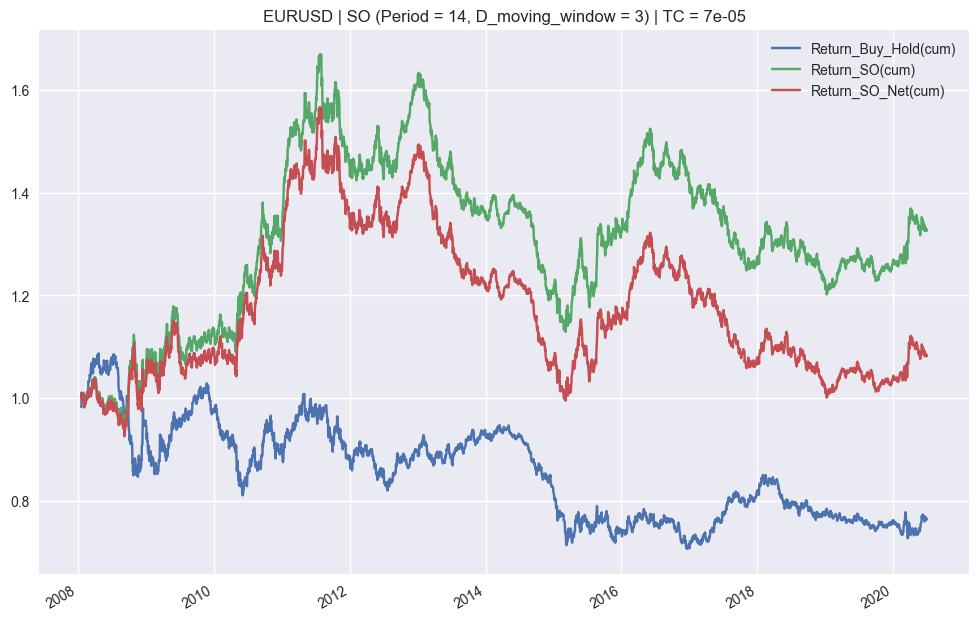

In [13]:
so1.plot_result()

In [14]:
so1.optimize_params(period_range=PERIOD_RANGE, D_mw_range=D_MW_RANGE)

array([27., 11.])

In [15]:
so2 = SO(symbol=SYMBOL2,
         period=PERIOD,
         D_mw=D_MW,
         start_date=START_DATE,
         end_date=END_DATE, 
         tc=TRADING_COST)
so2

SOBackTester(symbol: US30, period: 14, D_mw: 3, start_date: 2008-01-01, end_date: 2020-06-30)

In [16]:
so2.load_data(path = PATH2)
so2.data.head()

,Open,High,Low,Close,Rolling_High,Rolling_Low,K,D,Return_Buy_Hold(log),Return_Buy_Hold(cum)
2008-01-01,13262.9,13303.1,12981.1,13070.7,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,13070.8,13125.1,13009.9,13074.6,NaN,NaN,NaN,NaN,0.000298,1.000298
2008-01-03,13074.7,13112.9,12776.0,12817.8,NaN,NaN,NaN,NaN,-0.019837,0.980651
2008-01-06,12823.6,12891.7,12718.6,12803.5,NaN,NaN,NaN,NaN,-0.001116,0.979557
2008-01-07,12806.5,12894.6,12553.5,12574.5,NaN,NaN,NaN,NaN,-0.018048,0.962037


In [17]:
so2.run_strategy()
so2.result.head()

,Open,High,Low,Close,Rolling_High,Rolling_Low,K,D,Return_Buy_Hold(log),Return_Buy_Hold(cum),Position,Trades,Return_SO(log),Return_SO_Net(log),Return_SO(cum),Return_SO_Net(cum)
2008-01-23,12244.5,12371.8,12137.3,12371.8,12921.4,11410.5,63.624330,46.239039,0.010751,0.946529,1,0.0,0.010751,0.010751,1.010809,1.010809
2008-01-24,12366.8,12443.1,12144.4,12193.3,12921.4,11410.5,51.810179,54.710156,-0.014533,0.932873,-1,2.0,-0.014533,-0.014673,0.996225,0.996086
2008-01-27,12197.0,12354.2,12039.8,12314.3,12921.4,11410.5,59.818651,58.417720,0.009875,0.942130,1,2.0,-0.009875,-0.010015,0.986436,0.986160
2008-01-28,12315.3,12457.6,12296.6,12425.8,12921.4,11410.5,67.198359,59.609063,0.009014,0.950661,1,0.0,0.009014,0.009014,0.995368,0.995089
2008-01-29,12424.8,12633.8,12311.0,12318.0,12778.3,11410.5,66.347419,64.454810,-0.008713,0.942413,1,0.0,-0.008713,-0.008713,0.986733,0.986457


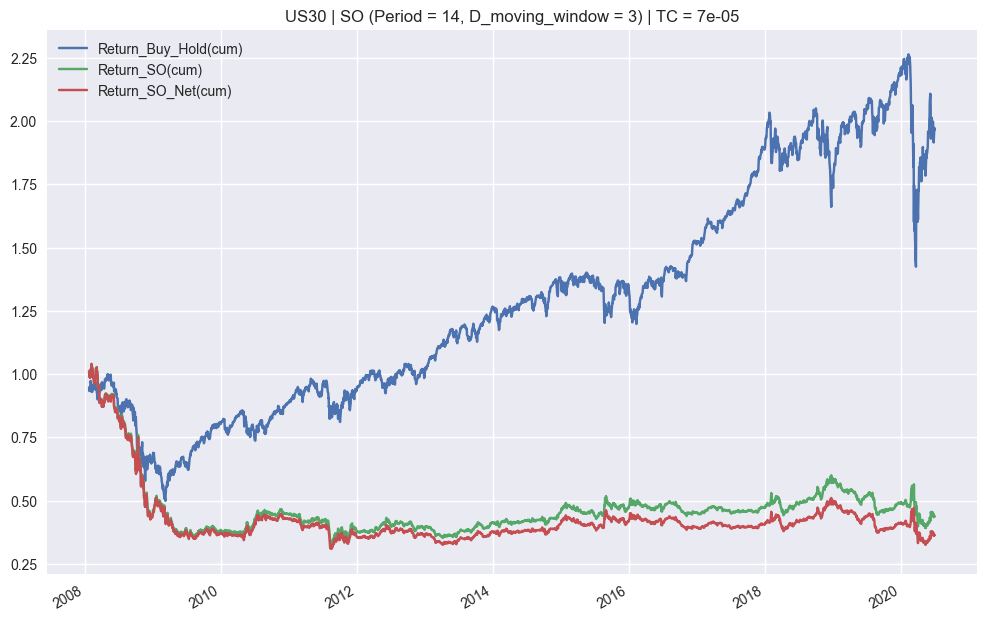

In [18]:
so2.plot_result()

In [19]:
so3 = SO(symbol=SYMBOL3,
         period=PERIOD,
         D_mw=D_MW,
         start_date=START_DATE,
         end_date=END_DATE, 
         tc=TRADING_COST)
so3

SOBackTester(symbol: XAUUSD, period: 14, D_mw: 3, start_date: 2008-01-01, end_date: 2020-06-30)

In [20]:
so3.load_data(path = PATH3)
so3.data.head()

,Open,High,Low,Close,Rolling_High,Rolling_Low,K,D,Return_Buy_Hold(log),Return_Buy_Hold(cum)
2008-01-01,833.90,861.46,833.90,857.31,NaN,NaN,NaN,NaN,NaN,NaN
2008-01-02,857.35,868.98,853.59,865.01,NaN,NaN,NaN,NaN,0.008941,1.008982
2008-01-03,865.03,868.84,854.61,859.70,NaN,NaN,NaN,NaN,-0.006158,1.002788
2008-01-05,859.07,859.27,858.67,858.97,NaN,NaN,NaN,NaN,-0.000849,1.001936
2008-01-06,858.67,865.06,855.33,858.19,NaN,NaN,NaN,NaN,-0.000908,1.001026


In [21]:
so3.run_strategy()
so3.result.head()

,Open,High,Low,Close,Rolling_High,Rolling_Low,K,D,Return_Buy_Hold(log),Return_Buy_Hold(cum),Position,Trades,Return_SO(log),Return_SO_Net(log),Return_SO(cum),Return_SO_Net(cum)
2008-01-22,892.34,895.840,876.55,890.49,914.430,849.56,63.095422,49.166984,-0.002075,1.038702,1,0.0,-0.002075,-0.002075,0.997927,0.997927
2008-01-23,890.66,913.455,889.28,912.80,914.430,849.56,97.487282,75.509994,0.024745,1.064726,1,0.0,0.024745,0.024745,1.022928,1.022928
2008-01-24,912.85,923.935,906.05,913.90,923.935,849.56,86.507563,82.363422,0.001204,1.066009,1,0.0,0.001204,0.001204,1.024161,1.024161
2008-01-27,913.25,929.505,911.00,928.92,929.505,849.56,99.268247,94.421031,0.016301,1.083529,1,0.0,0.016301,0.016301,1.040993,1.040993
2008-01-28,928.92,933.400,919.89,923.65,933.400,849.56,88.370706,91.382172,-0.005689,1.077382,-1,2.0,-0.005689,-0.005829,1.035088,1.034943


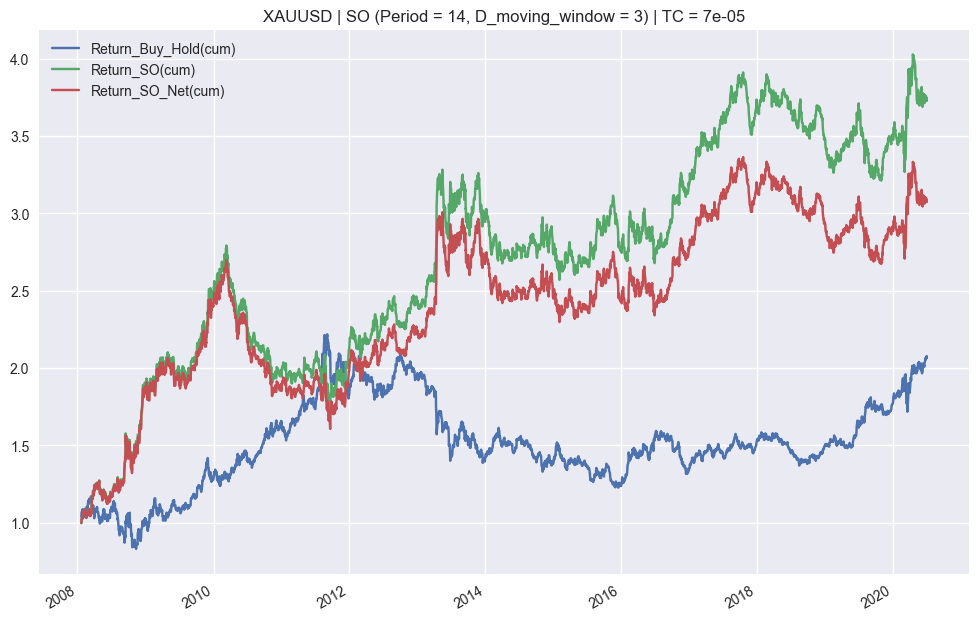

In [22]:
so3.plot_result()